# Ejercicio 01

La función `senial.m` retorna una señal de variable independiente discreta, y los instantes _n_ en los que está definida la misma.

Primero, se importan librerías y funciones necesarias:

* **matplotlib.pyplot**: permite graficar datos y visualizar señales.
* **numpy**: ofrece operaciones vectoriales sobre arreglos.
* **math**: contiene funciones matemáticas básicas (trigonometría, logaritmos, potencias, etc.).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.signal import lfilter

### TFTD numérica

La función `tftd_numeric(n, x)` implementa la **Transformada de Fourier en Tiempo Discreto** siguiendo la definición teórica sugerida por la cátedra en la práctica 5.

Evalúa la suma _X(e^j2πs) ≈ Σ x[n]·e^(-j2πsn)_ y utiliza un cajón para limitar el soporte.

In [2]:
# Definicion TFTD NumericNa (suma acotada)
def tftd_numeric(n, x, s=None, ds=0.001):
  """
  Realiza una TFTD numerica sobre el soporte de la señal de entrada x
  X(e^j2πs) = sum_N{x[n].e^-j2πsn}
  """
  n = np.asarray(n, dtype=int)
  x = np.asarray(x, dtype=complex)
    
  if s is None:
    s = np.arange(-0.5, 0.5, ds)

  X = np.zeros_like(s, dtype=complex)

  for k in range(len(s)):
    sk = s[k]
    # X(k) = sum( x[n] * exp(-j 2π s(k) n) )
    X[k] = np.sum(x * np.exp(-1j * 2 * np.pi * sk * n))

  return s, X

## Parte 1: Señal de Entrada

- Obtener señal x[n].
- Graficar x[n].
- Obtener aproximación de la TFTD de x[n].
- ¿Qué componentes de frecuencia identifica?

In [10]:
# Señal importada desde CSV y se obtiene x[n]
data = np.loadtxt("../data/senial_14253.csv", delimiter=",")
nx = data[:, 0].astype(int)
x = data[:, 1]

# Se define X(e^j2πs) y se obtiene magnitud y fase
sX, X = tftd_numeric(nx, x)
magX = np.abs(X)
phaseX = np.unwrap(np.angle(X))

Finalmente, se grafica la señal de entrada y sus componentes de frecuencia:

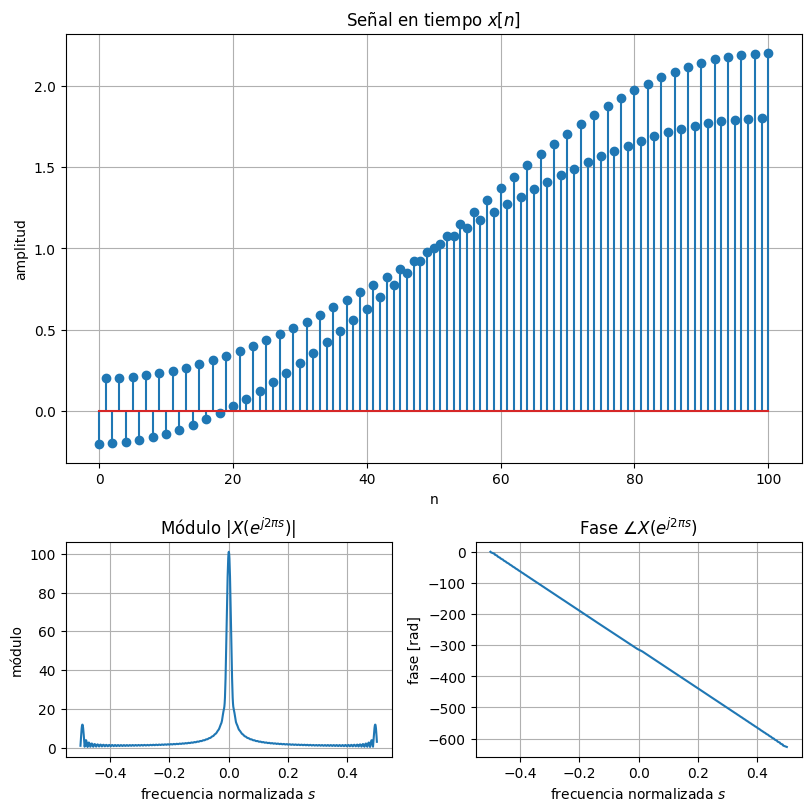

In [21]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

# Fila 1: x[n] ocupando todo el ancho
ax_time = fig.add_subplot(gs[0, :])
ax_time.stem(nx, x)
ax_time.set_title(r"Señal en tiempo $x[n]$")
ax_time.set_xlabel("n")
ax_time.set_ylabel("amplitud")
ax_time.grid(True)

# Fila 2, columna 1: |X(e^{j2πs})|
ax_mag = fig.add_subplot(gs[1, 0])
ax_mag.plot(sX, np.abs(X))
ax_mag.set_title(r"Módulo $|X(e^{j2\pi s})|$")
ax_mag.set_xlabel(r"frecuencia normalizada $s$")
ax_mag.set_ylabel("módulo")
ax_mag.grid(True)

# Fila 2, columna 2: ∠X(e^{j2πs})
ax_phase = fig.add_subplot(gs[1, 1])
ax_phase.plot(sX, np.unwrap(np.angle(X)))
ax_phase.set_title(r"Fase $\angle X(e^{j2\pi s})$")
ax_phase.set_xlabel(r"frecuencia normalizada $s$")
ax_phase.set_ylabel("fase [rad]")
ax_phase.grid(True)

plt.show()

## Parte 2: Sistemas

Se tienen cuatro sistemas descriptos por las siguientes ecuaciones en diferencias con los cuales se quiere procesar la señal anterior.

- 𝑦[𝑛] = 𝑥[𝑛] + 𝑥[𝑛 − 1]
- 𝑦[𝑛] = 𝑥[𝑛] − 𝑥[𝑛 − 1]
- 𝑦[𝑛] = 𝑥[𝑛] + 𝑥[𝑛 − 1] + 𝑦[𝑛 − 1]
- 𝑦[𝑛] = 𝑥[𝑛] − 𝑥[𝑛 − 1] − 𝑦[𝑛 - 1]

Se requiere:

- Codificar funciones que implementen cada sistema.
- Verificar respuestas impulsionales de cada uno de los sistemas.
- Obtener TFTD de las respuestas impulsionales.
- Graficar.

### Definición de Sistemas como Funciones

- Cada función aplica la ecuación en diferencias directamente.
- Se asumen condiciones iniciales nulas.
- `np.zeros_like(x)` garantiza mismo tamaño y tipo que la entrada.

In [5]:
def s1(x):
    x = x.astype(float)
    y = 0.5*x.copy()            # término x[n]
    if len(x) > 1:
        y[1:] += 0.5 * x[:-1]   # término x[n−1]
    return y

def s2(x):
    x = x.astype(float)
    y = 0.5*x.copy()
    if len(x) > 1:
        y[1:] += -0.5 * x[:-1]
    return y

def s3(x):
    x = x.astype(float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)

    # n = 0
    y[0] = 0.25 * x[0]

    # n ≥ 1
    for n in range(1, N):
        y[n] = 0.25*x[n] + 0.25*x[n-1] + 0.5*y[n-1]

    return y


def s4(x):
    x = x.astype(float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)

    # n = 0
    y[0] = 0.25 * x[0]

    # n ≥ 1
    for n in range(1, N):
        y[n] = 0.25*x[n] - 0.25*x[n-1] - 0.5*y[n-1]

    return y



### Respuesta Impulsional de los Sistemas

Se genera una **delta de Kronecker**, utilizada como señal de entrada para excitar los cuatro sistemas. A partir de ella se obtienen las **respuestas impulsionales** implementadas manualmente.

En paralelo, se calculan las mismas respuestas mediante la función estándar `lfilter`, usando los coeficientes que representan cada ecuación en diferencias. Esto permite verificar que las implementaciones propias producen resultados equivalentes a los del modelo analítico del sistema.

Finalmente, se crean **gráficos comparativos** entre cada respuesta manual y su versión obtenida con `lfilter`. permitiendo validar visualmente el comportamiento de cada sistema.

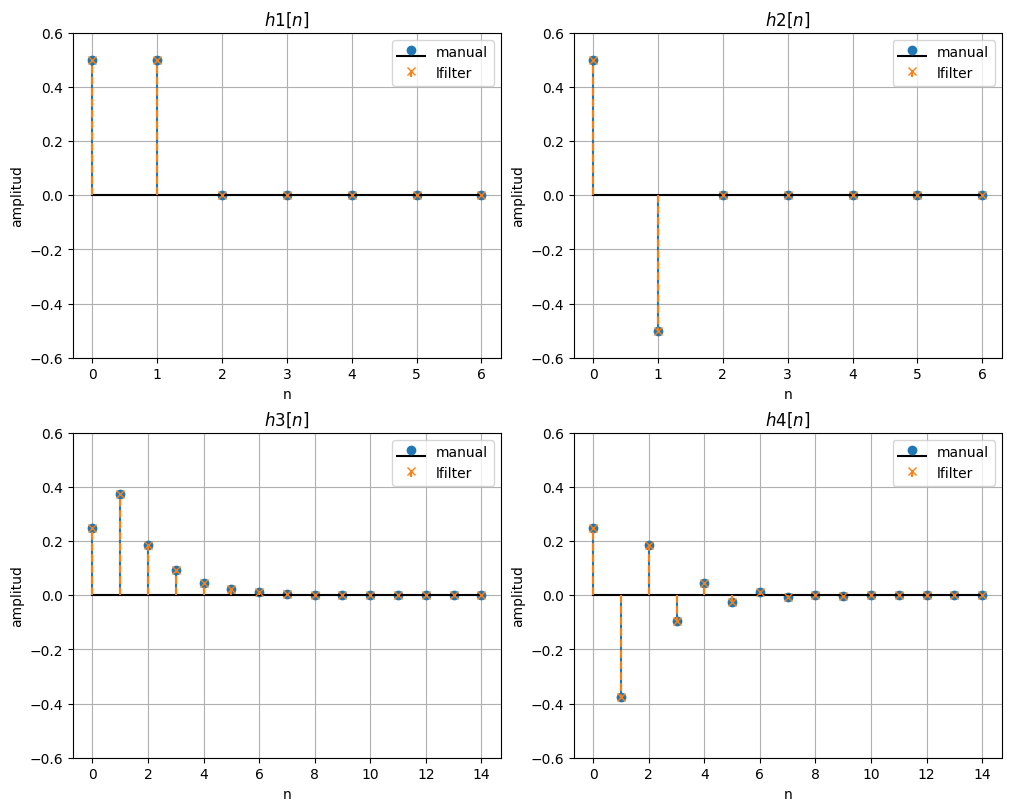

In [26]:
# ============================
# 1) Señal delta de Kronecker
# ============================
nd = np.arange(0, 50)     # longitud "larga" para calcular las h[n]
d = np.zeros_like(nd)
d[0] = 1                  # d[n]

# ============================
# 2) Respuestas impulsionales
# ============================
h1 = s1(d)
h2 = s2(d)
h3 = s3(d)
h4 = s4(d)

# ============================
# 3) Respuestas impulsionales usando lfilter
# ============================
b1, a1 = [0.5,  0.5], [1.0]          # y[n] = 0.5·x[n] + 0.5·x[n−1]
b2, a2 = [0.5, -0.5], [1.0]          # y[n] = 0.5·x[n] − 0.5·x[n−1]
b3, a3 = [0.25, 0.25], [1.0, -0.5]   # y[n] = 0.25·x[n] + 0.25·x[n−1] + 0.5·y[n−1]
b4, a4 = [0.25, -0.25], [1.0,  0.5]  # y[n] = 0.25·x[n] − 0.25·x[n−1] − 0.5·y[n−1]

h1_lf = lfilter(b1, a1, d)
h2_lf = lfilter(b2, a2, d)
h3_lf = lfilter(b3, a3, d)
h4_lf = lfilter(b4, a4, d)

# ============================
# Función auxiliar para recortar
# ============================
def recortar_nd(nd, h, margen=3, tol=1e-3):
    """Devuelve nd e h recortados hasta el último índice
    donde |h| > tol, más 'margen' muestras adicionales.
    """
    idx = np.where(np.abs(h) > tol)[0]
    if len(idx) == 0:
        # Si es ~0, se grafica solo las primeras 'margen' muestras
        fin = min(margen, len(nd))
    else:
        fin = min(idx[-1] + 1 + margen, len(nd))
    return nd[:fin], h[:fin]

# ============================
# Gráficos comparativos 2x2
# ============================
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.ravel()  # para indexar como un vector: 0,1,2,3

def comparar(ax, nd, h, h_lf, titulo):
    nd_plot, h_plot   = recortar_nd(nd, h, margen=5, tol=1e-3)
    _,      hlf_plot  = recortar_nd(nd, h_lf, margen=5, tol=1e-3)

    ax.stem(nd_plot,  h_plot,   markerfmt='o', linefmt='C0-', basefmt='k')
    ax.stem(nd_plot,  hlf_plot, markerfmt='x', linefmt='C1--', basefmt=' ')
    ax.set_title(titulo)
    ax.set_xlabel("n")
    ax.set_ylabel("amplitud")
    ax.set_ylim(-0.6, 0.6)  # rango fijo de amplitud
    ax.grid(True)
    ax.legend(["manual", "lfilter"], loc="best")

comparar(axes[0], nd, h1, h1_lf, r"$h1[n]$")
comparar(axes[1], nd, h2, h2_lf, r"$h2[n]$")
comparar(axes[2], nd, h3, h3_lf, r"$h3[n]$")
comparar(axes[3], nd, h4, h4_lf, r"$h4[n]$")

plt.show()


### Transformada de Fourier en Tiempo Discreto de las respuestas impulsionales

En esta etapa se calcula la **TFTD numérica** de las respuestas impulsionales _h1[n]_, _h2[n]_, _h3[n]_ y _h4[n]_, obteniendo las transformadas _H1(e^j2πs)_, _H2(e^j2πs)_, _H3(e^j2πs)_ y _H4(e^j2πs)_. 

Este análisis permite observar el comportamiento en frecuencia de cada sistema a partir de su respuesta al impulso.


Para cada sistema se muestran **módulo** y **fase** de su TFTD.


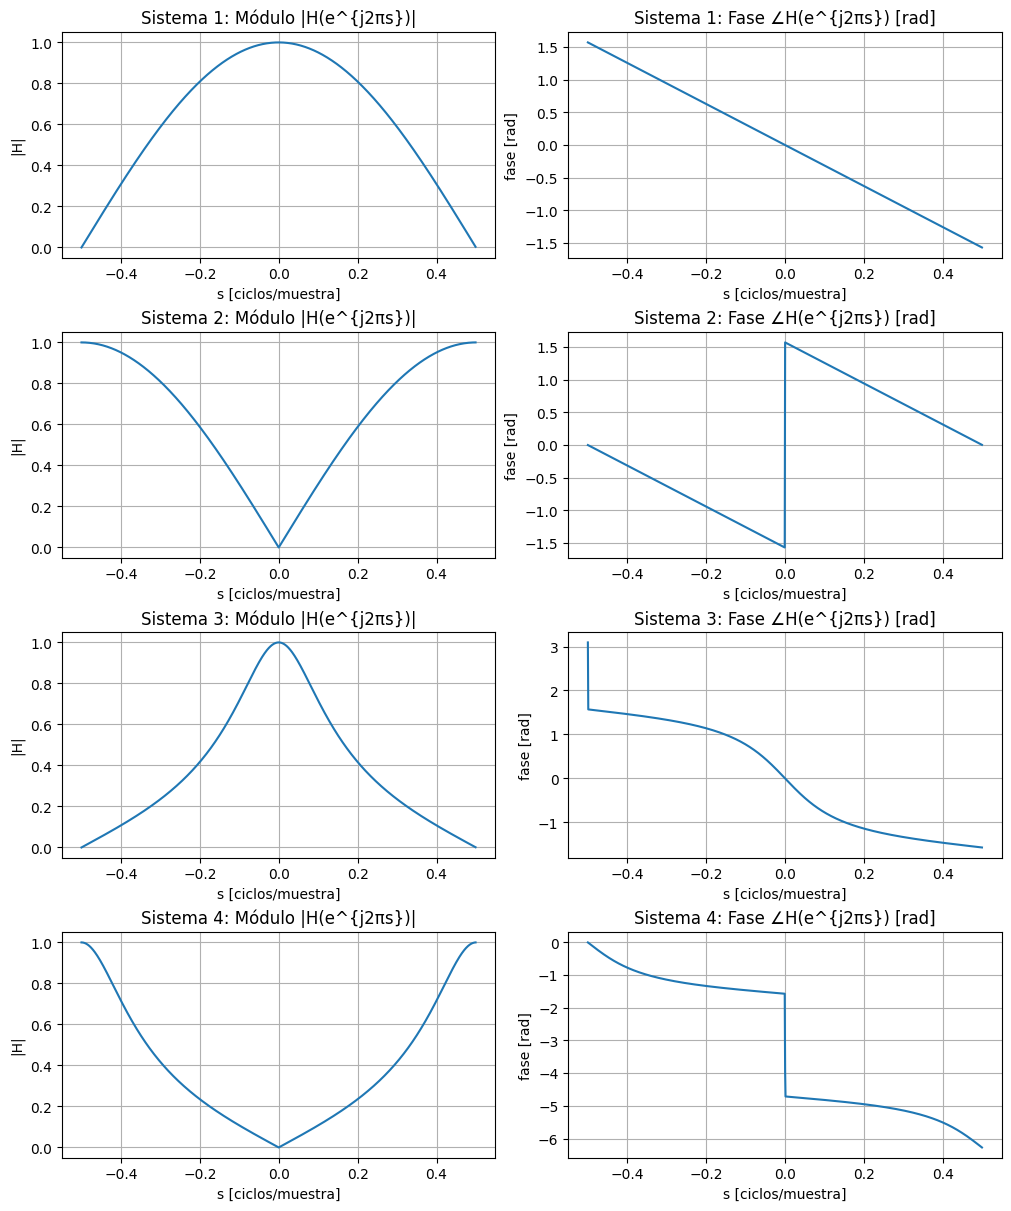

In [7]:
# --- 2) TFTD numérica de cada h ---
sH1, H1 = tftd_numeric(nd, h1)
sH2, H2 = tftd_numeric(nd, h2)
sH3, H3 = tftd_numeric(nd, h3)
sH4, H4 = tftd_numeric(nd, h4)

# --- 3) Magnitud y fase (fase desenvuelta) ---
def mag_phase(H):
    return np.abs(H), np.unwrap(np.angle(H))

m1, p1 = mag_phase(H1)
m2, p2 = mag_phase(H2)
m3, p3 = mag_phase(H3)
m4, p4 = mag_phase(H4)

# --- 4) Gráficos 4x2 (Magnitud | Fase) ---
fig, axes = plt.subplots(4, 2, figsize=(10, 12), constrained_layout=True)

def plot_pair(ax_mag, ax_phase, s, mag, phase, name):
    ax_mag.plot(s, mag)
    ax_mag.set_title(f"{name}: Módulo |H(e^{{j2πs}})|")
    ax_mag.set_xlabel("s [ciclos/muestra]")
    ax_mag.set_ylabel("|H|")
    ax_mag.grid(True)

    ax_phase.plot(s, phase)
    ax_phase.set_title(f"{name}: Fase ∠H(e^{{j2πs}}) [rad]")
    ax_phase.set_xlabel("s [ciclos/muestra]")
    ax_phase.set_ylabel("fase [rad]")
    ax_phase.grid(True)

plot_pair(axes[0,0], axes[0,1], sH1, m1, p1, "Sistema 1")
plot_pair(axes[1,0], axes[1,1], sH2, m2, p2, "Sistema 2")
plot_pair(axes[2,0], axes[2,1], sH3, m3, p3, "Sistema 3")
plot_pair(axes[3,0], axes[3,1], sH4, m4, p4, "Sistema 4")

plt.show()

## Parte 3: Señales de Salida

En esta sección se presentan las señales de salida obtenidas al aplicar la señal de entrada _x[n]_ a cada uno de los sistemas definidos.

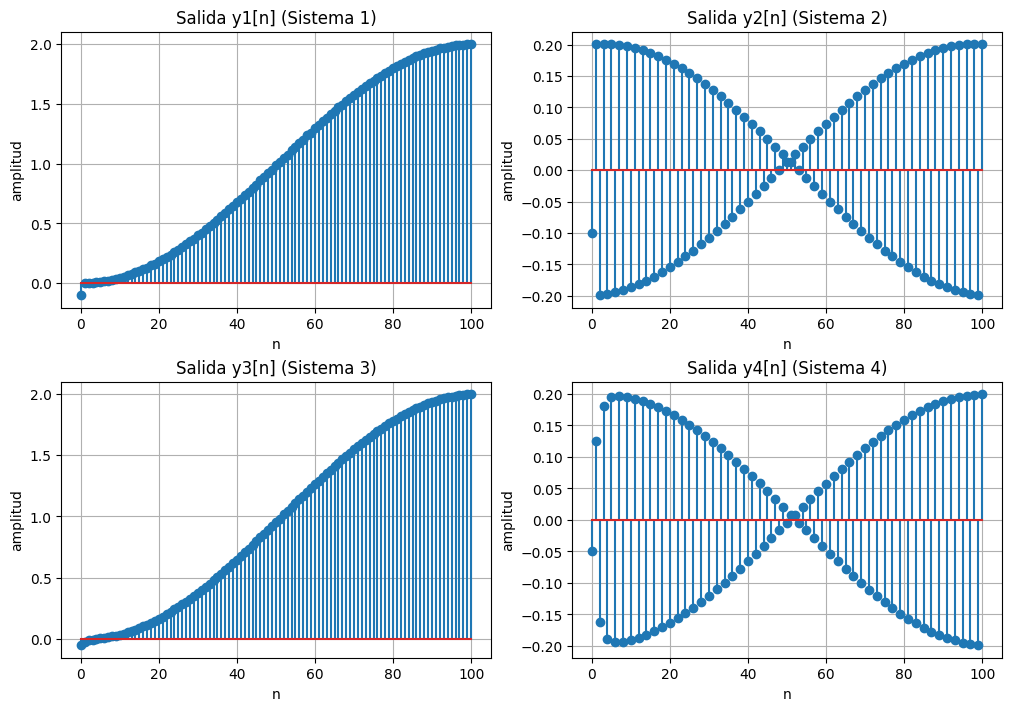

In [8]:
# =========================================
# 1) Salidas de los sistemas para la señal x[n]
# =========================================
y1 = s1(x)
y2 = s2(x)
y3 = s3(x)
y4 = s4(x)

# =========================================
# 2) Grilla 2×2 de gráficos en tiempo
# =========================================
fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)

def comparar(ax, n, y, titulo):
    ax.stem(n, y)
    ax.set_title(titulo)
    ax.set_xlabel("n")
    ax.set_ylabel("amplitud")
    ax.grid(True)

comparar(axes[0,0], nx, y1, "Salida y1[n] (Sistema 1)")
comparar(axes[0,1], nx, y2, "Salida y2[n] (Sistema 2)")
comparar(axes[1,0], nx, y3, "Salida y3[n] (Sistema 3)")
comparar(axes[1,1], nx, y4, "Salida y4[n] (Sistema 4)")

plt.show()



---

## Salidas en el dominio de la frecuencia

A continuación se representan las transformadas de Fourier en tiempo discreto _Y(e^{j2\pi s})_ para cada sistema.

En cada caso se muestran el módulo y la fase de la respuesta, lo que permite analizar la ganancia y el desplazamiento de fase que cada sistema produce sobre la señal de entrada.


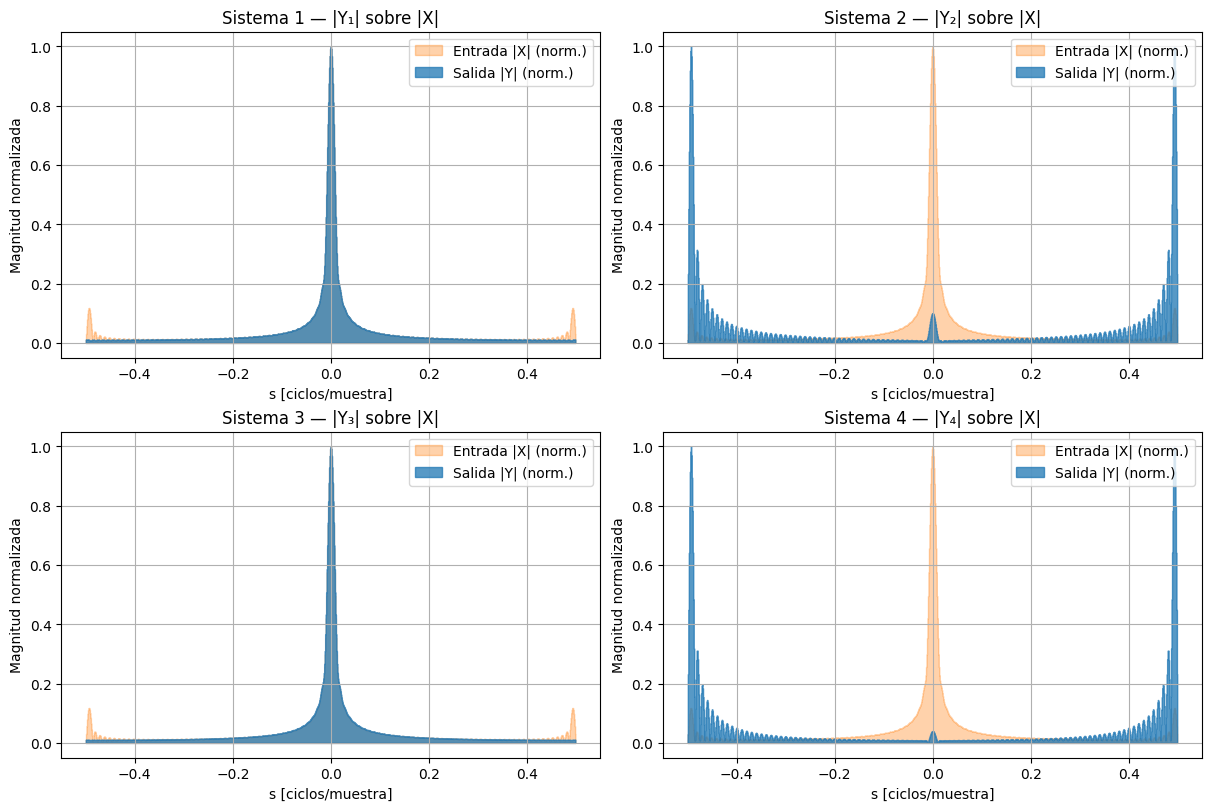

In [9]:
# =========================================
# Magnitud normalizada de la señal de entrada
# =========================================
mX = np.abs(X) / np.max(np.abs(X))   # magnitud normalizada
sX = sX

# =========================================
# TFTD de cada salida Yk
# =========================================
sY1, Y1 = tftd_numeric(nx, y1)
sY2, Y2 = tftd_numeric(nx, y2)
sY3, Y3 = tftd_numeric(nx, y3)
sY4, Y4 = tftd_numeric(nx, y4)

m1 = np.abs(Y1) / np.max(np.abs(Y1))
m2 = np.abs(Y2) / np.max(np.abs(Y2))
m3 = np.abs(Y3) / np.max(np.abs(Y3))
m4 = np.abs(Y4) / np.max(np.abs(Y4))

# =========================================
# Grilla 2×2 — Áreas superpuestas
# =========================================
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

def plot_fill(ax, sY, mY, sX, mX, title):
    # Área de la señal de entrada
    ax.fill_between(sX, mX, step='mid', color='C1', alpha=0.35,
                    label="Entrada |X| (norm.)")

    # Área del sistema (encima)
    ax.fill_between(sY, mY, step='mid', color='C0', alpha=0.75,
                    label="Salida |Y| (norm.)")

    ax.set_title(title)
    ax.set_xlabel("s [ciclos/muestra]")
    ax.set_ylabel("Magnitud normalizada")
    ax.grid(True)
    ax.legend(loc="upper right")


plot_fill(axes[0,0], sY1, m1, sX, mX, "Sistema 1 — |Y₁| sobre |X|")
plot_fill(axes[0,1], sY2, m2, sX, mX, "Sistema 2 — |Y₂| sobre |X|")
plot_fill(axes[1,0], sY3, m3, sX, mX, "Sistema 3 — |Y₃| sobre |X|")
plot_fill(axes[1,1], sY4, m4, sX, mX, "Sistema 4 — |Y₄| sobre |X|")

plt.show()
